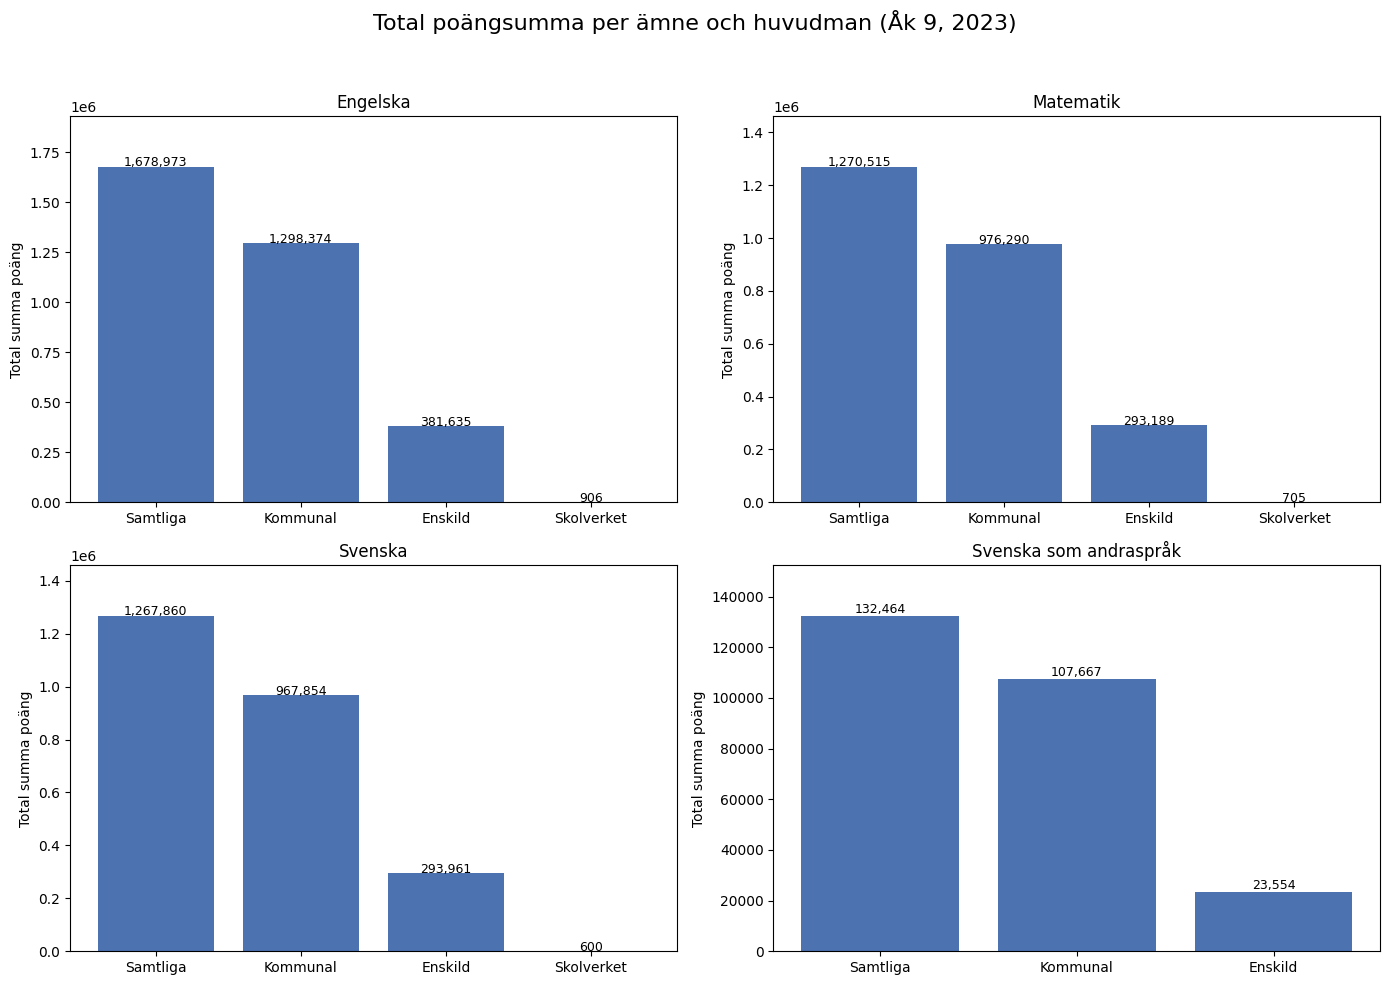

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# mapp för att spara grafer
os.makedirs("visualiseringar", exist_ok=True)


filnamn = "riket2023_åk9_np.xlsx"

ämnen = ["Engelska", "Matematik", "Svenska", "Svenska som andraspråk"]

# Kolumnnamn 
kolumner = [
    "Plats", "Huvudman",
    "Totalt (A-F)", "Flickor (A-F)", "Pojkar (A-F)",
    "Totalt (A-E)", "Flickor (A-E)", "Pojkar (A-E)",
    "Totalt (poäng)", "Flickor (poäng)", "Pojkar (poäng)"
]

# Lagra alla dataframes
dataframes = {}

for ämne in ämnen:
    df = pd.read_excel(filnamn, sheet_name=ämne, skiprows=8)
    df.columns = kolumner
    df = df.dropna(how="all")  # Ta bort helt tomma rader
    df = df.dropna(subset=["Plats", "Huvudman"], how="all")  # Ta bort rader där båda är tomma
    df = df.reset_index(drop=True)
    dataframes[ämne] = df

# subplotfigur
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Total poängsumma per ämne och huvudman (Åk 9, 2023)", fontsize=16)

for i, ämne in enumerate(ämnen):
    ax = axs[i // 2, i % 2]

    df = dataframes[ämne]
    df_riket = df[df["Plats"] == "Riket"].copy()

    # Omvandla till numeriskt
    df_riket["Totalt (poäng)"] = pd.to_numeric(df_riket["Totalt (poäng)"], errors='coerce')
    df_riket["Totalt (A-F)"] = pd.to_numeric(df_riket["Totalt (A-F)"], errors='coerce')

    # Räkna ut total summa poäng
    df_riket["Total summa poäng"] = df_riket["Totalt (poäng)"] * df_riket["Totalt (A-F)"]

    # Sortera
    df_riket = df_riket.sort_values("Total summa poäng", ascending=False)

    # Skapa stapeldiagram
    bars = ax.bar(df_riket["Huvudman"], df_riket["Total summa poäng"], color="#4c72b0")

    ax.set_title(ämne)
    ax.set_ylabel("Total summa poäng")
    ax.set_ylim(0, df_riket["Total summa poäng"].max() * 1.15)

    # Visa värde på staplar
    for bar in bars:
        y = bar.get_height()
        if pd.notna(y):
            ax.text(bar.get_x() + bar.get_width() / 2, y + 1000, f"{int(y):,}", ha='center', fontsize=9)

# Justera layout & spara
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("visualiseringar/totalt_poängsumma_per_ämne.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()


In [64]:
import pandas as pd
import plotly_express as px


# Ge Filnamn
file_path = "betyg_o_prov_riksnivå.xlsx"

# Raderna som innehåller rubriker och metadata, Hoppa över de första 5.
df_temp = pd.read_excel(file_path, skiprows=5)

# 
df_final = df_temp.iloc[4:].copy()
df_final.columns = [
    'Läsår',
    'Elever_totalt', 'Elever_flickor', 'Elever_pojkar',
    'Med_slutbetyg_totalt', 'Med_slutbetyg_flickor', 'Med_slutbetyg_pojkar',
    'Godkända_betyg_totalt', 'Godkända_betyg_flickor', 'Godkända_betyg_pojkar'
]

df_final = df_final[df_final['Läsår'].notna()].reset_index(drop=True)

df_final.replace(".", pd.NA, inplace=True)

# Konvertera kolumner till numeriska
kolumner = [
    'Elever_totalt', 'Elever_flickor', 'Elever_pojkar',
    'Godkända_betyg_totalt', 'Godkända_betyg_flickor', 'Godkända_betyg_pojkar'
]
df_final[kolumner] = df_final[kolumner].apply(pd.to_numeric)


# DataFrame, beräknad andel utan godkänt betyg
df_andel = pd.DataFrame()
df_andel["Läsår"] = df_final["Läsår"]
df_andel["Totalt"] = 1 - df_final["Godkända_betyg_totalt"] / df_final["Elever_totalt"]
df_andel["Flickor"] = 1 - df_final["Godkända_betyg_flickor"] / df_final["Elever_flickor"]
df_andel["Pojkar"] = 1 - df_final["Godkända_betyg_pojkar"] / df_final["Elever_pojkar"]

df_andel_melted = df_andel.melt(id_vars="Läsår", var_name="Kön", value_name="Andel utan godkänt")

# Skapar linjediagram
fig_a = px.line(
    df_andel_melted,
    x="Läsår",
    y="Andel utan godkänt",
    color="Kön",
    markers=True,
    title="Andel elever som saknar godkänt betyg i ett eller flera ämnen (2018–2023)"
)

# Sparas som en HTML-fil
fig_a.write_html("andel_utan_godkänt_18_23.html")


excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

merit_df = None
for sheet in sheet_names:
    if "merit" in sheet.lower() or "värde" in sheet.lower():
        merit_df = pd.read_excel(file_path, sheet_name=sheet)
        break

# Behandla om rätt sheet hittas.
if merit_df is not None:
    # Städar meritvärde-tabellen
    merit_df_clean = merit_df.copy()
    merit_df_clean.columns = merit_df_clean.iloc[3]
    merit_df_clean = merit_df_clean.iloc[4:].reset_index(drop=True)

    # Gör kolumn namn tydligare.
    merit_df_clean.rename(columns={merit_df_clean.columns[0]: "Läsår"}, inplace=True)
    merit_df_clean = merit_df_clean[["Läsår", "Totalt", "Flickor", "Pojkar"]]
    merit_df_clean = merit_df_clean[merit_df_clean["Läsår"].notna()]
    merit_df_clean.replace(".", pd.NA, inplace=True)

    # Konvertera till numeriskt format
    merit_df_clean[["Totalt", "Flickor", "Pojkar"]] = merit_df_clean[["Totalt", "Flickor", "Pojkar"]].apply(pd.to_numeric)

    # Smält datan för linjediagram
    merit_melted = merit_df_clean.melt(id_vars="Läsår", var_name="Kön", value_name="Meritvärde")

    # Skapa linjediagram
    fig_b = px.line(
        merit_melted,
        x="Läsår",
        y="Meritvärde",
        color="Kön",
        markers=True,
        title="Meritvärde för 16 ämnen (2018–2023)"
    )

    # Spara som HTML
    fig_b.write_html("meritvärde_16ämnen_18_23.html")
else:
    print("Inget meritvärde i Excel-filen.")


Inget meritvärde i Excel-filen.


C:\Users\Thumblock\AppData\Local\Temp\ipykernel_154228\1130858512.py:22: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

